# Minimum energy control of a crane
The goal of this live script, is to control a hanging crane with minimum energy. 
The following equations describe a linearized model of the hanging crane shown 
in the figure

$$\left(I+m \ell^{2}\right) \ddot{\theta}(t)+m g \ell \theta(t)=-m \ell \ddot{x}(t)$$

$$(M+m) \ddot{x}(t)+b \dot{x}(t)+m \ell \ddot{\theta}(t)=u(t)$$

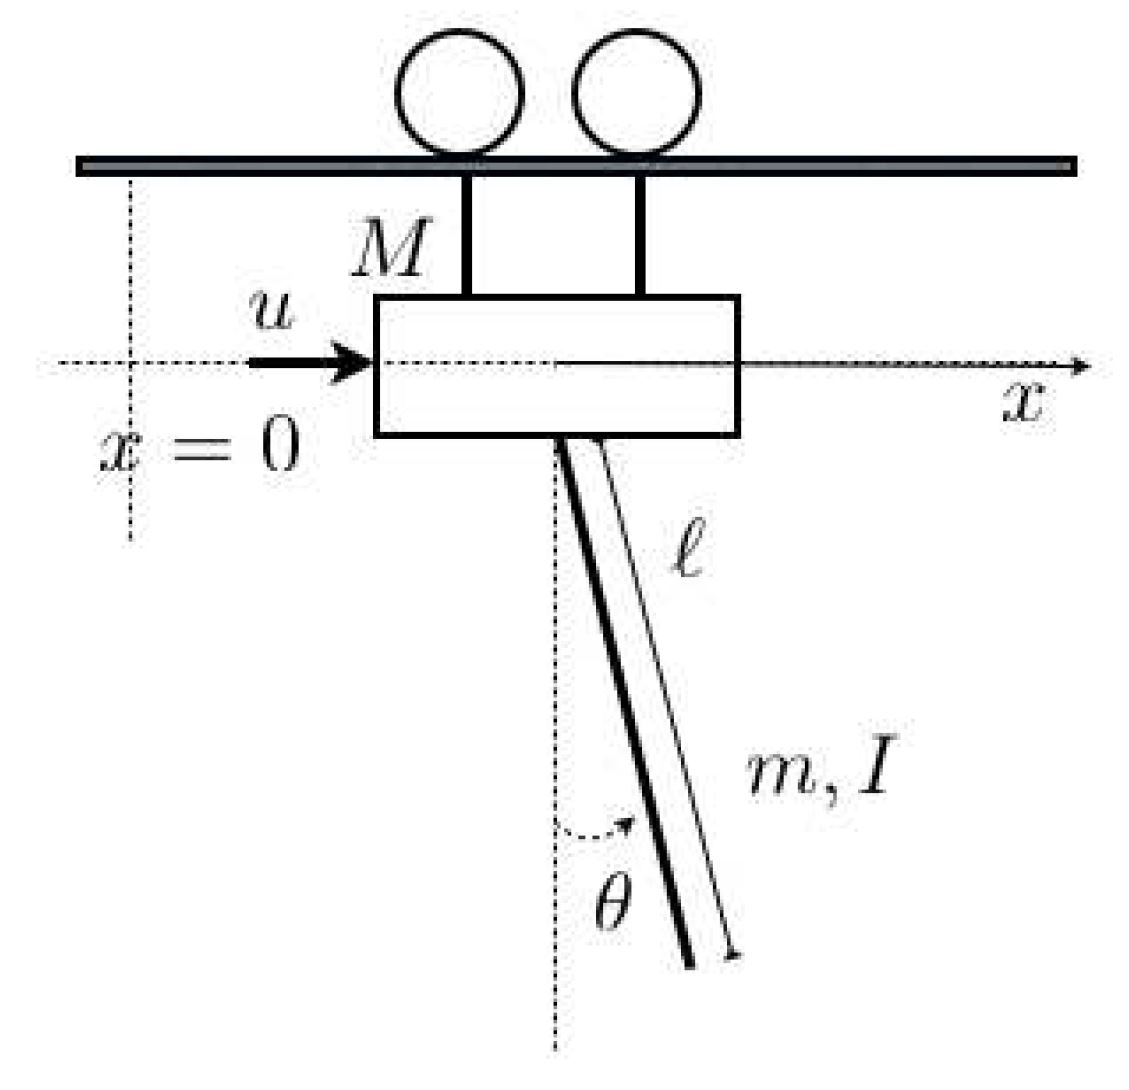

In the equations above it assumed that 
$m=0.2, \quad M=1, \quad b=0.05, \quad I=0.01, \quad g=9.8, \quad \ell=0.5$. Suppose that the initial conditions of the system are $x(0)=x_{0}, \ \dot{x}(0)=0, \ \theta(0)=0,\ \theta(0)=0$, where 
$x_{0}=0.1$ and the desired final condition is $x(T)=0, \dot{x}(T)=0, \theta(T)=0, 
\dot{\theta}(T)=0$, where $T$ is the final time. After discretization at sampling 
period $\tau=0.1$, assuming a zero order hold mechanism for the control input 
$u(t)=u_{k}, t \in[k \tau,(k+1) \tau), k \in\{0,1, \ldots, h-1\}$, we end up 
in a linear system

$$x_{k+1}=A x_{k}+B u_{k}, \quad k \in\{0,1, \ldots, h-1\}$$

where $h:=\frac{T}{\tau}$ is an integer. Suppose that the energy needed to 
apply control input $u_k$ in a given time period of length $\tau$ is

$$g\left(u_{k}\right)=u_{k}^{2}+3 \times 10^{-4} u_{k}^{4}$$

The overall energy in a time interval of h steps is as follows:

$$\sum_{k=0}^{h-1} g\left(u_{k}\right)$$

The goal is to compute the control input that drives the crane from the initial 
position to the desired final position while minimizing energy. 

To this effect, we start by noticing that since we must have $x_k=0$, the 
last $n$ inputs are determined by $x_{h-n}$

$$x_{h}=0=\underbrace{\left[A^{n-1} B \quad A^{n-2} B \quad \cdots \quad B\right]}_{\mathcal{C}} 
\cdot \underbrace{\left[\begin{array}{c}u_{h-n} \\ u_{h-n+1} \\ \vdots \\ u_{h-1}\end{array}\right]}_{\tilde 
u}+A^{n} x_{h-n}.$$

and $x_{h-n}$ can be written in terms of the first $n-h$ inputs

$$x_{h-n}=\left[A^{h-n-1} B \quad A^{h-n-2} B \quad \cdots \quad B\right] \cdot \underbrace{\left[\begin{array}{c}u_{0} 
\\ u_{1} \\ \vdots \\ u_{h-n-1}\end{array}\right]}_{\bar{u}}+A^{h-n} x_{0}$$

from which

$$\tilde{u}=M \bar{u}+v$$

$$v =-\mathcal{C}^{-1} A^{h} x_{0} $$

$$M =-\mathcal{C}^{-1}\left[A^{h-1} B \quad \ldots \quad A^{n} B\right].$$

Then we obtain the following unconstrained problem

$$\min _{u_{0}, \ldots, u_{h-1-n}}\left(\sum_{k=0}^{h-1-n} g\left(u_{k}\right)\right)+\sum_{i=1}^{n} 
g\left(e_{i}^{\top}\left(v+M\left[\begin{array}{c}u_{0} \\\vdots \\u_{h-1-n}\end{array}\right]\right)\right)$$

where $e_{i}=\left[\begin{array}{lllllll}0 & \ldots & 0 & 1 & 0 & \ldots 
& 0\end{array}\right]^{\top}$ is vector with zeros except at position $i$ where 
it is equal to one. This problem can be solved, e.g., by a gradient method 
(guaranteed to converge to the optimal solution if $g$ is convex).

The function `minenergycrane` computes the optimal input vector u and the 
total cost of the execution for the desired time $h \in \{5,6,7,8,9\}$, using 
the gradient descend method and also the Newton method. The computation of the 
first and second order derivatives is omited here. For each value of $h$ an initial 
estimate close to the optimal solution is picked in order to reduce the run 
time, but this can be changed.

In [ ]:
import numpy as np
from scipy import signal
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib ipympl

In [ ]:
def g_(u):
    go = (u**2+(3e-4)*u**4)
    return go

In [ ]:
def gu(u):
    gu0 = (2*u+(12e-4)*u**3)
    return gu0

In [ ]:
def guu(u):
    guu0 = (2+(36e-4)*u**2)
    return guu0

In [ ]:
def minenergycrane(h):

    #definition of the model & discretization
    m = 0.2
    M = 1
    b = 0.05
    I = 0.01
    g = 9.8
    l = 0.5
    p = (I+m*l**2)*(M+m)-m**2*l**2
    Ac = np.array([[0, 1, 0, 0],
        [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p,   0],
        [0,      0,              0,           1],
        [0,  (m*l*b)/p,       -m*g*l*(M+m)/p,  0]])
    Bc = np.array([[0],[(I+m*l**2)/p], [0],[-m*l/p]])
    x0 = np.array([[0.1], [0], [0], [0]])
    n = 4
    tau = 0.1
    A, B = signal.cont2discrete((Ac, Bc, np.zeros((1,n)),np.array([0])), tau)[:2]    
    
    #define functions g gu and matrices v and M 
    v = -np.linalg.inv(np.array([A@A@A@B, A@A@B, A@B, B]).reshape(4,4)).T@np.linalg.matrix_power(A,h)@x0
    N = np.zeros((4,h-4))
    for k in range(h-4):
        N[:,[k]] = np.linalg.matrix_power(A,(h-1-k))@B
    
    M = -np.linalg.inv(np.array([A@A@A@B, A@A@B, A@B, B]).reshape(4,4)).T@N
    e1 = np.array([[1], [0], [0], [0]])
    e2 = np.array([[0], [1], [0], [0]])
    e3 = np.array([[0], [0], [1], [0]])
    e4 = np.array([[0], [0], [0], [1]])
    

    #gradient method adjust parameters depending on h
    if h==5:
        ubar = np.zeros((h-4, 1)) # initial condition
        nmax = 10
        epsilongrad = 0.01
        epsilon = 0.00001
        alphamax = 0.001
    elif h==6:
        ubar = np.array([[-10], [10]]) # initial condition
        nmax = 10
        epsilon = 0.00001
        epsilongrad = 0.02
        alphamax = 0.001
    elif h==7:
        ubar = np.array([[-10], [10], [10]]) # initial condition
        nmax = 10
        epsilon = 0.00001
        epsilongrad = 0.008
        alphamax = 0.001
    elif h==8:
        ubar = np.array([[-5], [5], [5], [0]]) # initial condition
        nmax = 10
        epsilon = 0.00001
        epsilongrad = 0.045
        alphamax = 0.0005
    elif h==9:
        ubar = np.array([[-5], [2], [3], [1], [0]]) # initial condition
        nmax = 10
        epsilon = 0.00001
        epsilongrad = 0.045
        alphamax = 0.0005
    
    if h > 4:
        alphavec = np.arange(0,alphamax, epsilon)
        C = np.zeros((nmax+10,1))
        Ubar = np.zeros((h-4,nmax+10+1))
        Ubar[:,[0]] = ubar # can be choosen differently to accelerate the method
        d_ = np.zeros((h-4,1))
        for ind in range(nmax):
            # compute gradient
            for k in range(h-4):
                d_[k,0] = gu(e1.T@(v+M@ubar))@M[0,[k]] + gu(e2.T@(v+M@ubar))@M[1,[k]] + gu(e3.T@(v+M@ubar))@M[2,[k]] + gu(e4.T@(v+M@ubar))@M[3,[k]]
            
            d = gu(ubar) + d_
            
            H = np.zeros((h-4,h-4))
            for i1 in range(h-4):
                for i2 in range(h-4):
                    H[i1,i2] = guu(e1.T@(v+M@ubar))*M[0,i1]*M[0,i2] + guu(e2.T@(v+M@ubar))*M[1,i1]*M[1,i2] + guu(e3.T@(v+M@ubar))*M[2,i1]*M[2,i2] + guu(e4.T@(v+M@ubar))*M[3,i1]*M[3,i2]
                
            H = H+np.diag(guu(ubar))
            d = np.linalg.inv(H)@d
            
            c = np.zeros(alphavec.shape[0])
            ubar_ = np.zeros((5,alphavec.shape[0]))
            for it in range(alphavec.shape[0]):
                ubar_[:,[it]] = ubar -alphavec[it]*d
                # maximum descend along gradient direction
                c[it] = np.sum(g_(ubar_[:,[it]])) + g_(e1.T@(v+M@ubar_[:,[it]])) + g_(e2.T@(v+M@ubar_[:,[it]])) + g_(e3.T@(v+M@ubar_[:,[it]])) + g_(e4.T@(v+M@ubar_[:,[it]]))
            
            minc = np.min(c)
            indopt = np.argmin(c)
            ubar = ubar-alphavec[indopt]*d
            Ubar[:,[ind+1]] = ubar
            C[ind] = minc
        
        # start the pure newton method with initial estimate ubar
        for ind in range(nmax+1,nmax+10): # again 10 iterations
            #compute gradient
            for k in range(h-4):
                d_[k,0] = gu(e1.T@(v+M@ubar))*M[0,[k]] + gu(e2.T@(v+M@ubar))*M[1,[k]] + gu(e3.T@(v+M@ubar))*M[2,[k]] + gu(e4.T@(v+M@ubar))*M[3,[k]]
            
            d = gu(ubar) + d_
            H = np.zeros((h-4,h-4))
            for i1 in range(h-4):
                for i2 in range(h-4):
                    H[i1,i2] = guu(e1.T@(v+M@ubar))*M[0,[i1]]*M[0,[i2]] + guu(e2.T@(v+M@ubar))*M[1,[i1]]*M[1,[i2]] + guu(e3.T@(v+M@ubar))*M[2,[i1]]*M[2,[i2]] + guu(e4.T@(v+M@ubar))*M[3,[i1]]*M[3,[i2]]
            
            H = H+np.diag((guu(ubar).T)[0])
            ubar = ubar-np.linalg.inv(H)@d
            Ubar[:,[ind+1]] = ubar
            C[ind] = np.sum(g_(ubar)) + g_(e1.T@(v+M@ubar)) + g_(e2.T@(v+M@ubar)) + g_(e3.T@(v+M@ubar)) + g_(e4.T@(v+M@ubar))
               
        cost = C[-1]
        u = np.hstack([ubar.T[0], (e1.T@(v+M@ubar))[0], (e2.T@(v+M@ubar))[0],  (e3.T@(v+M@ubar))[0], (e4.T@(v+M@ubar))[0]])
    else:
        u = -np.linalg.inv(np.array([A@A@A@B, A@A@B, A@B, B]).reshape(4,4)).T@np.matrix_power(A,h)@x0
        u = u.T
        cost = g_(u[0]) + g_(u[1]) + g_(u[2]) + g_(u[3])
    

    # plots
    if(1):
        x = np.zeros((4,h+1))
        x[:,[0]] = x0
        costcheck = 0
        for k in range(h):
            x[:,[k+1]] = A@x[:,[k]] + B*u[k]
            costcheck = costcheck+g_(u[k])

        t = tau*np.arange(h+1)
        
        f = plt.figure()
        ax = plt.subplot(1, 2, 1)
        stepU = np.hstack((u, u[-1]))
        ax.step(t, stepU, where='post')
        ax.set_xlabel('time')
        ax.set_ylabel('u')
        ax.grid(True)
        
        ax=plt.subplot(1, 2, 2)
        ax.stem(t,x[0,:],linefmt='g', markerfmt='go')
        ax.stem(t,x[1,:],linefmt='b', markerfmt='bo')
        ax.stem(t,x[2,:],linefmt='r', markerfmt='ro')
        ax.stem(t,x[3,:],linefmt='k', markerfmt='ko')
        ax.set_xlabel('time')
        ax.grid(True)
        ax.legend(['x','xdot','theta','thetadot'])
    
    return u, cost, A, B

In [ ]:
# Set the desired time length (between 5 and 9)
h = 9
u, cost, A, B = minenergycrane(h)

In [ ]:
u

In [ ]:
cost

In [ ]:
A

In [ ]:
B